## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [173]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [174]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [175]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [176]:
df.nunique()



user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [177]:
df.drop_duplicates('user_id').converted.mean()

0.11956955647936569

e. The number of times the `new_page` and `treatment` don't match.

In [178]:
a = ((df.group=='treatment') & (df.landing_page=='old_page'))
b = ((df.group=='control') & (df.landing_page=='new_page'))
a.sum()+b.sum()

3893

f. Do any of the rows have missing values?

In [179]:
sum(df.isnull().any(axis=1))

0

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [180]:
c1 = (df['landing_page']=='new_page') & (df['group']=='treatment')
c2 = (df['landing_page']=='old_page') & (df['group']=='control')
df2 = df[c1 | c2]

In [181]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [182]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. There is one **user_id** repeated in **df2**.  What is it?

In [183]:
df2.user_id.duplicated().sum()

1

c. What is the row information for the repeat **user_id**? 

In [184]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [185]:
df2.drop(2893, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [186]:
df2[df2['converted']==1]['user_id'].shape[0]/df2['user_id'].shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [187]:
df2.query('converted == True & group == "control"').count() /(df2.query('group=="control"').count())

user_id         0.120386
timestamp       0.120386
group           0.120386
landing_page    0.120386
converted       0.120386
dtype: float64

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [188]:
df2.query('converted == True & group == "treatment"').count() /(df2.query('group=="treatment"').count())

user_id         0.118808
timestamp       0.118808
group           0.118808
landing_page    0.118808
converted       0.118808
dtype: float64

d. What is the probability that an individual received the new page?

In [189]:
df2[df2['landing_page']=='new_page']['user_id'].shape[0]/df2['user_id'].shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

** Considering that the conversion rate was slightly higher for the control group, I would fail to reject the null hypothesis and say that no the new page does not help with the conversion rate.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

The null hypothesis is that new page has either the same or a smaller conversion rate than the new landing page. The alternative hypothesis is the new landing page has a higher conversion rate. In order to reject the null hypothesis, we need to be 95% sure the new landing has a giher conversion rate.

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem. <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [190]:
p_new = df2['converted'].mean()

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [191]:
p_old = df2['converted'].mean()

c. What is $n_{new}$, the number of individuals in the treatment group?

In [192]:
n_new = df2.query('group == "treatment"')['user_id'].count()
print(n_new)

145310


d. What is $n_{old}$, the number of individuals in the control group?

In [193]:
n_old = df2.query('group == "control"')['user_id'].count()
print(n_old)

145274


e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [194]:
new_page_converted = df2["converted"].sample(n_new, replace=True)
p_new = new_page_converted.mean()
print(p_new)

0.119888514211


f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [195]:
old_page_converted = df2["converted"].sample(n_old, replace=True)
p_old = old_page_converted.mean()
print(p_old)

0.119684182992


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [196]:
p_new - p_old

0.00020433121885818362

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [197]:

p_diffs = []

for _ in range(10000):

    new_page_converted = np.random.binomial(n_new,p_new)

    old_page_converted = np.random.binomial(n_old, p_old)

    diff = new_page_converted/n_new - old_page_converted/n_old

    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([   10.,    46.,   307.,  1159.,  2345.,  2833.,  2124.,   895.,
          234.,    47.]),
 array([-0.00462017, -0.00372684, -0.00283351, -0.00194018, -0.00104685,
        -0.00015351,  0.00073982,  0.00163315,  0.00252648,  0.00341981,
         0.00431315]),
 <a list of 10 Patch objects>)

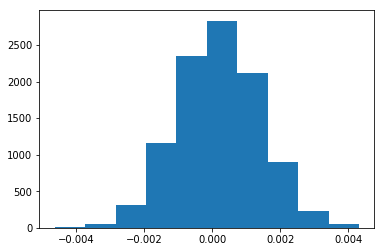

In [198]:
p_diffs = np.array(p_diffs)

plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [199]:
obs_diff = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()

(p_diffs > obs_diff).mean()

0.93089999999999995

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.** In part J I just calculated the p-value, which means it's the chances of observing that statistic if the null was true. Considering the null hyopthesis is that the difference would be greater or less than zero, currently the difference is less than zero, along with a very high p-value, we fail to reject the null hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [200]:
import statsmodels.api as sm

convert_old = sum((df2.group == 'control') & (df2.converted == 1))
convert_new = sum((df2.group == 'treatment') & (df2.converted == 1))
n_old = sum(df2.group == 'control')
n_new = sum(df2.group == 'treatment')

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [201]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


In [202]:
from scipy.stats import norm
norm.cdf(z_score) #how significant our z_score is

0.094941687240975514

In [203]:
norm.ppf(1-(0.05)) #critical value of 95% confidence

1.6448536269514722

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.** The z-score shows us that it is too small to achieve 95% confidence. The same is true for the p-value, which is under the 0.95 needed to reach the 95% condience threshold. Because of this we fail to reject the null hypothesis. This is in line with the findings in j and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.** Since we are using categorical data with only two outcomes we should use logistic data.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [204]:
df2['intercept'] = 1
# This will be 1 when treatment and 0 if control
df2['ab_page'] = (df2.group == 'treatment').astype(int)
df2.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [205]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [206]:
result = log_mod.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-04-16 20:04 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Put your answer here.** The p-value in this case is 0.1899. The reason why it's nearly twice as big the p-vale in part II is because this a one  tailed test instead of a two tailed test.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [207]:
df_country = pd.read_csv('countries.csv')
df_country = df_country.fillna('undefined')

In [208]:
df_all = df_country.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [209]:
df_all[['CA', 'UK', 'US']] = pd.get_dummies(df_all['country'])
df_all.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [210]:
model = sm.Logit(df_all['converted'], df_all[['intercept', 'CA', 'UK', ]])
results = model.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-04-16 20:04 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

Because the p-value is over .05 for both the UK and Canada we would fail to reject the hypothesis.

Even after the country dependent conversion, there is no p-value under 0.05. That means there is not enough statistical significant evidence to reject the null hypothesis. In conclusion we fail to reject the null hypothesis, and the company should continue to use old landing page.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [211]:
df_all['ab_UK'] = df_all['ab_page'] * df_all['UK']
df_all['ab_CA'] = df_all['ab_page'] * df_all['CA']
lm3 = sm.Logit(df_all['converted'], df_all[['intercept', 'ab_page', 'UK' , 'CA', 'ab_UK', 'ab_CA']])
results = lm3.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-04-16 20:04 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
ab_UK         0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
ab_CA        -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
==================================================================

"""

Again seeing that in both ab_UK and ab_CA the p-value is over .05 we can not see any clear significant effects between page and country.

In [212]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0